# **Pneumonia Detection from X-Ray Images Using ResNet and VGG Transfer Learning** <br>

<img src = 'https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2016/05/18/13/02/ww5r032t-8col-jpg.jpg' width="500" class="center">
<br>

Given the objective we will work on X-Ray Images Data and we have choosen Pytorch as our framework due to the assignment requirement.

We have decided to Use two models via Transfer Learning:

1. ResNet (Residual Network
2. VGG (Visual Geometry Group)

### **Dataset Description**

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

It is still quite small as compared to other DL datasets present, But since we will be using Transfer Learning we will be taking advantage of the weights of low level layers and features like lines, shapes, etc that were already detected in the pretrained data.

**Acknowledgements**

Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

License: CC BY 4.0

Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

# **Steps**:
The process is as follows:

1. [Importing Necessary Libraries](#1)
2. [Loading Data and Transformations](#2)
3. [Data Preparation](#3)
4. [Checking for GPU and setting it up](#4)
5. [Creating Evaluation Metric Functions](#5)
6. [Creating Base Classifier Class and ResNet and VGG Model Classes](#6)
7. [Training and Evaluation of both Models](#7)
8. [Setting up Hyper-Parameters](#8)
9. [ResNet Training](#9)
10. [VGG Training](#10)
11. [Comparing Results on Training & Validation Data](#11)
12. [Testing Model on Test Data](#12)
13. [Model Evaluation on Different Metrics](#13)
14. [Predictions vs Actual Label](#14)
15. [Saving the Best Model](#15)
16. [Conclusion](#16)<br><br>

<a id='1'></a>
# 1. Importing Necessary Libraries

* We will import basic libraries like numpy, pandas and some visualization libraries like matplotlib and seaborn

* We will import Computer Vision Cv2 package as well and mainly Pytorch

* We will also import few metrics for evaluation

In [2]:
# Basic Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.image import imread
import seaborn as sns
import random
import copy
import os
# Cv2 and Pytorch
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
# For Evaluation
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn import metrics

<a id='2'></a>
# 2. Loading Data and Transformations

We have to transform images to tensors while loading so are going to apply the following transforms

1. Resize and crop to 224x224 as many images are of different sizes
2. Data Augmentation: random horizontal flip, random rotation and random grayscale
3. Convert images into PyTorch tensors

In [3]:
data_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray'

pneumonia_files = os.listdir(data_dir + "/train/PNEUMONIA")
print('No. of training examples for Pneumonia:', len(pneumonia_files))
normal_files = os.listdir(data_dir + "/train/NORMAL")
print('No. of training examples for Normal:', len(normal_files))
dataset = ImageFolder(data_dir+'/train', 
                      transform=tt.Compose([tt.Resize(255),
                                            tt.CenterCrop(224),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            tt.ToTensor()
                                           ]))
print(dataset)
print("Classes in the dataset are: ",dataset.classes)

No. of training examples for Pneumonia: 3876
No. of training examples for Normal: 1342
Dataset ImageFolder
    Number of datapoints: 5216
    Root location: ../input/chest-xray-pneumonia/chest_xray/chest_xray/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomGrayscale(p=0.1)
               RandomAffine(degrees=(0, 0), translate=(0.05, 0.05))
               ToTensor()
           )
Classes in the dataset are:  ['NORMAL', 'PNEUMONIA']


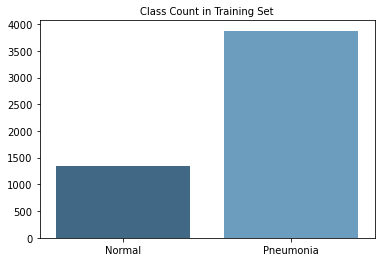

In [4]:
# Checking the counts of both Classes

train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/train/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])]})
sns.barplot(data=train_samplesize,palette="Blues_d").set_title('Class Count in Training Set', fontsize=10)
plt.show()

Here we can see clearly that our data is imbalanced this can create issue in modelling as model might become biased towards the more frequent class. we will try to compensate this by weighting the loss of each class/label.

Label:  PNEUMONIA (1)


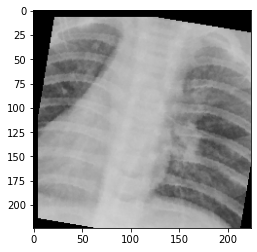

In [5]:
# Funtion to output a single image
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*dataset[2534])

Label:  NORMAL (0)


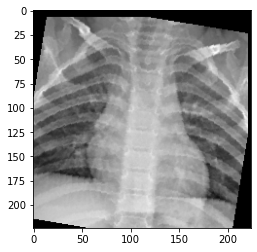

In [6]:
show_example(*dataset[150])

<a id='3'></a>
# 3. Data Preparation

We will do a 80-20 split of training data into Train and Validation datasets

In [7]:
# set random seed so we get the same sampling every time for reproducibility
random_seed = 2023
torch.manual_seed(random_seed)

train_size = round(len(dataset)*0.8) # 80%
val_size = len(dataset) - train_size # 20%

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(4173, 1043)

We will select batch size of 128 to reduce the time for 1 epoch and parameter updates

In [8]:
batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

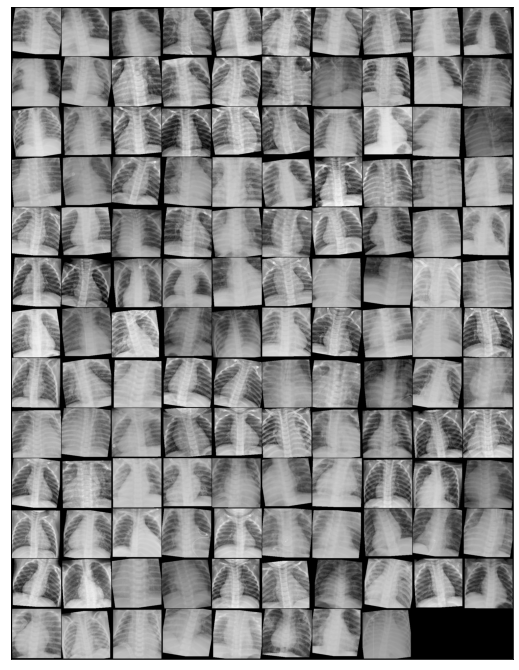

In [9]:
# Function to output a complete batch
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

<a id='4'></a>
# 4. Checking for GPU and Setting it up

We will check if GPU is available and if yes we will set it up since it will reduce the training time significantly and won't put a lot extensive computation on CPU.
We will use Google Colab for this task.

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cuda')

In [11]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

Here we will define a function that will move our batches/data to the new selected device.
1. --iter__ method to retrieve batches
2. --len__ method to get the # of batches

In [12]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

<a id='5'></a>
# 5. Creating Evaluation Metric Functions

In [13]:
#Function to get accuracy 
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

#function to get F1_score, precision, recall and prediction
def get_eval_metrics(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    
    # precision, recall, and F1
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))
    
    return precision,recall,f1,preds

<a id='6'></a>
# 6. Creating Base Classifier Class and ResNet and VGG Model Classes

In [14]:
class PneumoniaModelBase(nn.Module):
    
    # this is for loading the batch of train image and outputting its loss, accuracy 
    # & predictions
    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)                                      
        loss = F.cross_entropy(out, labels, weight=weight)      
        acc,preds = accuracy(out, labels)                       
        
        return {'train_loss': loss, 'train_acc':acc}
       
    # this is for computing the train average loss and acc for each epoch
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]       
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['train_acc'] for x in outputs]          
        epoch_acc = torch.stack(batch_accs).mean()              
        
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
    # this is for loading the batch of val/test image and outputting its loss, accuracy, 
    # predictions & labels
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)                                      
        loss = F.cross_entropy(out, labels)                     
        acc,preds = accuracy(out, labels)                       
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    # detach extracts only the needed number, or other numbers will crowd memory
    
    # this is for computing the validation average loss and acc for each epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]         
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]            
        epoch_acc = torch.stack(batch_accs).mean()              
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # this is for printing out the results after each epoch
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))
    
    # this is for using on the test set, it outputs the average loss and acc, 
    # and outputs the predictions
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()              
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}      

### ResNet

ResNet models use Residual Blocks with a normal CNN model which is actually feeding the input to the next output

<img src = 'https://i.stack.imgur.com/kBFIf.png' width="400">



We will use **ResNet50** Architechture for our model, the reason for using ResNet is that it significantly increases the performance over normal CNNs

<img src = 'https://www.researchgate.net/publication/331364877/figure/fig3/AS:741856270901252@1553883726825/Left-ResNet50-architecture-Blocks-with-dotted-line-represents-modules-that-might-be.png' width="600"><br>


In [15]:
# This is the model class for ResNet 
class PneumoniaResnet(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features 
        self.network.fc = nn.Linear(num_features, 2) #Making the Output Layer
        print(self.network)
    
    def forward(self, xb):
        return self.network(xb)

### VGG

To compare with ResNet we will use VGG (Visual Geometry Group) model, it has smaller kernel sizes in each ConV layer, and the combination of small kernal sizes emulate larger receptive fields. Its learning procedure is simlar to AlexNet. It is usually of 16 or 19 layers
We will use **VGG16**

<img src = 'https://miro.medium.com/max/1192/1*Q_bg1E3trWcjdk9_jnVGwg.png' width="1000">


In [16]:
# This is the model class for VGG 
class PneumoniaVGG(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network =models.vgg16()
        
        for param in self.network.features.parameters():
            param.required_grad = False

        num_features = self.network.classifier[6].in_features
        features = list(self.network.classifier.children())[:-1] 
        features.extend([nn.Linear(num_features, 2)])
        self.network.classifier = nn.Sequential(*features) #Making the Output Layer
        print(self.network)
    
    def forward(self, xb):
        return self.network(xb)

In [17]:
'''torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage
and speed up computations but we won’t be able to backprop (which we don’t want in an evaluation  phase)'''

@torch.no_grad()


def evaluate(model, val_loader):
    '''Evaluate: this simply calls the validation functions we defined in the base model class above and returns the output. 
This function is called inside the **fit** function.'''
    '''model.eval() set specific layers like dropout and batchnorm to evaluation mode 
    (dropout won’t drop activations, batchnorm will use running estimates instead of batch statistics)'''
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    '''Get_LR: for getting the learning rate of each epoch, 
so that one can store them if a learning rate scheduler is used, to keep track of the changes.'''
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(epochs, lr, model, train_loader, val_loader, weight, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    
    '''FIT: this is the main function to fit the model. 
We pass in our model and dataloaders and other hyperparameters. 
There are some codes that were commented out. These are some other methods that 
I tried but they did not seem to help with performance, such as weight decay, 
gradient clipping and one-cycle learning rate scheduler.'''
    
    torch.cuda.empty_cache()
    history = {}    
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)

    best_loss = 1
    for epoch in range(epochs):
        
        # Training Phase 
        '''model.train() enables specific layers like dropout and batchnorm to train mode and starts training'''
        model.train() 
        train_outputs = []      
        lrs = []
        
        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']                          
            train_outputs.append(outputs)
            # get the train average loss and acc for each epoch
            train_results = model.train_epoch_end(train_outputs)                        
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()                                     
            optimizer.zero_grad()                                 
    
        val_results = evaluate(model, val_loader)
        
        if val_results['val_loss'] < best_loss and epoch + 1 > 10:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())        
        # print results
        model.epoch_end(epoch, train_results, val_results)

        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}
        
        # update performance dictionary
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
    
    model.load_state_dict(best_model_wts)                      
    
    return history, optimizer, best_loss

<a id='7'></a>
# 7. Training and Evaluation of both Models

In [18]:
#Making sure that data and models are on the same device (Cpu or Gpu)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
print("ResNet Model Structure: \n\n")
model1 = to_device(PneumoniaResnet(), device)
print("\n\nVGG Model Structure: \n\n")
model2 = to_device(PneumoniaVGG(), device)

ResNet Model Structure: 




Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

<a id='8'></a>
# 8. Setting Up Hyper-parameters

In [19]:
epochs = 20
lr = 0.0001
grad_clip = None
weight_decay = 1e-4
opt_func = torch.optim.Adam
weight = torch.FloatTensor([3876/(1342+3876), 1342/(1342+3876)]).to(device)  #Trying to put more weight on minority class

<a id='9'></a>
# 9. ResNet Training

In [20]:
print("ResNet Model Training:\n\n")
history_resnet, optimizer_resnet, best_loss_resnet = fit(epochs, lr, model1, train_dl, val_dl, weight, 
                                    grad_clip=grad_clip, 
                                    weight_decay=weight_decay, 
                                    opt_func=opt_func)

ResNet Model Training:


Epoch [1], train_loss: 0.1618, train_acc: 0.9353, val_loss: 0.5672, val_acc: 0.7915
Epoch [2], train_loss: 0.0573, train_acc: 0.9804, val_loss: 0.2825, val_acc: 0.9016
Epoch [3], train_loss: 0.0514, train_acc: 0.9802, val_loss: 0.0445, val_acc: 0.9891
Epoch [4], train_loss: 0.0372, train_acc: 0.9863, val_loss: 0.0392, val_acc: 0.9883
Epoch [5], train_loss: 0.0326, train_acc: 0.9873, val_loss: 0.0555, val_acc: 0.9738
Epoch [6], train_loss: 0.0258, train_acc: 0.9924, val_loss: 0.0307, val_acc: 0.9891
Epoch [7], train_loss: 0.0284, train_acc: 0.9893, val_loss: 0.0332, val_acc: 0.9906
Epoch [8], train_loss: 0.0168, train_acc: 0.9948, val_loss: 0.0360, val_acc: 0.9891
Epoch [9], train_loss: 0.0131, train_acc: 0.9948, val_loss: 0.0726, val_acc: 0.9742
Epoch [10], train_loss: 0.0194, train_acc: 0.9916, val_loss: 0.0616, val_acc: 0.9731
Epoch [11], train_loss: 0.0130, train_acc: 0.9937, val_loss: 0.0403, val_acc: 0.9891
Epoch [12], train_loss: 0.0103, train_acc: 0.9965

<a id='10'></a>
# 10. VGG Training

In [21]:
print("VGG Model Training:\n\n")
history_vgg, optimizer_vgg, best_loss_vgg = fit(epochs, lr, model2, train_dl, val_dl, weight, 
                                    grad_clip=grad_clip, 
                                    weight_decay=weight_decay, 
                                    opt_func=opt_func)

VGG Model Training:


Epoch [1], train_loss: 0.6769, train_acc: 0.6356, val_loss: 0.5792, val_acc: 0.8426
Epoch [2], train_loss: 0.3646, train_acc: 0.8561, val_loss: 0.2806, val_acc: 0.8786
Epoch [3], train_loss: 0.2267, train_acc: 0.9066, val_loss: 0.2091, val_acc: 0.8950
Epoch [4], train_loss: 0.1854, train_acc: 0.9270, val_loss: 0.1534, val_acc: 0.9301
Epoch [5], train_loss: 0.1771, train_acc: 0.9296, val_loss: 0.1933, val_acc: 0.9047
Epoch [6], train_loss: 0.2293, train_acc: 0.9057, val_loss: 0.1369, val_acc: 0.9360
Epoch [7], train_loss: 0.1431, train_acc: 0.9440, val_loss: 0.1480, val_acc: 0.9469
Epoch [8], train_loss: 0.1599, train_acc: 0.9352, val_loss: 0.1217, val_acc: 0.9559
Epoch [9], train_loss: 0.1295, train_acc: 0.9463, val_loss: 0.1112, val_acc: 0.9512
Epoch [10], train_loss: 0.1316, train_acc: 0.9471, val_loss: 0.1360, val_acc: 0.9442
Epoch [11], train_loss: 0.1501, train_acc: 0.9411, val_loss: 0.1091, val_acc: 0.9500
Epoch [12], train_loss: 0.1228, train_acc: 0.9508, v

<a id='11'></a>
# 11. Accuracy and Loss Plots

We made plots of the accuracy and loss for the training and validation data. This gives us an idea of how our model is performing (e.g., underfitting, overfitting).

In [22]:
# Checking the best Loss of both models
print('Best Resnet Model loss is:', best_loss_resnet)
print('Best VGG Model loss is:', best_loss_vgg)

Best Resnet Model loss is: 0.030819280073046684
Best VGG Model loss is: 0.07994073629379272


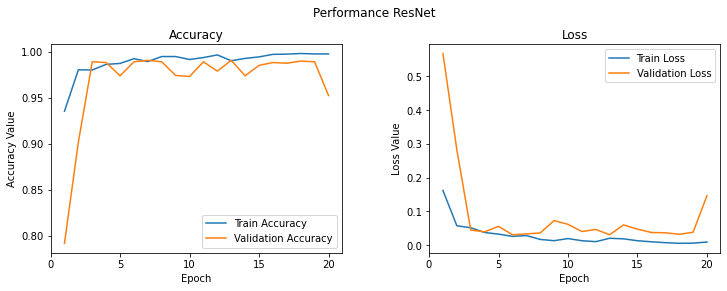

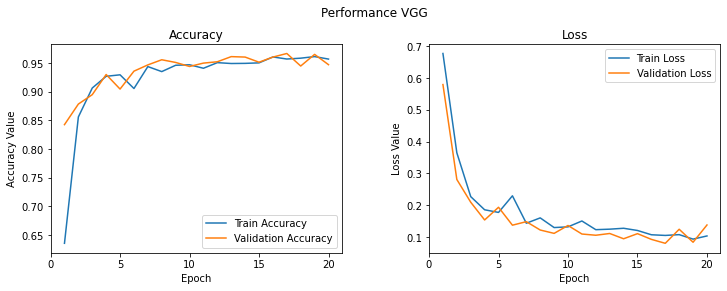

In [23]:
# Plot Accuracy and Loss of ResNet

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance ResNet', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history_resnet['train_acc'], label='Train Accuracy')
ax1.plot(epoch_list, history_resnet['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_resnet['train_loss'], label='Train Loss')
ax2.plot(epoch_list, history_resnet['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


# Plot Accuracy and Loss of VGG

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance VGG', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history_vgg['train_acc'], label='Train Accuracy')
ax1.plot(epoch_list, history_vgg['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_vgg['train_loss'], label='Train Loss')
ax2.plot(epoch_list, history_vgg['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

<a id='12'></a>
# 12. Testing Model on Test Data

Now we will check our model's performance on Test Data, before that we will check the data imbalance in test data as well

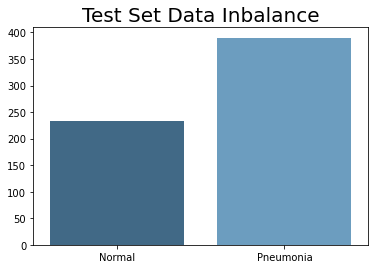

In [24]:
test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/test/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/test/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/test/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/test/PNEUMONIA')])]})

sns.barplot(data=test_samplesize,palette="Blues_d").set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

In [25]:
# Creating a function to get predictions from a model
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [model.validation_step(batch) for batch in test_loader] 
    results = model.test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [26]:
test_dataset = ImageFolder(data_dir+'/test', 
                           transform=tt.Compose([tt.Resize(255),
                                                 tt.CenterCrop(224),                                                              
                                                 tt.ToTensor()
                                                ]))

In [27]:
# Getting Predictions on Test Data also getting loss and accuracy

test_dl = DataLoader(test_dataset, batch_size=256)
test_dl = DeviceDataLoader(test_dl, device)
print("ResNet Test Loss and Accuracy\n")
preds_resnet,labels_resnet = test_predict(model1, test_dl)
print("\n\nVGG Test Loss and Accuracy\n")
preds_vgg,labels_vgg = test_predict(model2, test_dl)


ResNet Test Loss and Accuracy

test_loss: 0.4048, test_acc: 0.9036


VGG Test Loss and Accuracy

test_loss: 0.6741, test_acc: 0.8400


<a id='13'></a>
# 13. Model Evaluation on Different Metrics

We will use few other metrics to properly compare models

1. Recall, Precision, F1_Score
2. Confusion Matrix
3. ROC Curve

In [28]:
def classification_report(labels, preds, model_name):
    prediction_test = preds
    y_test = labels
    # Print the prediction accuracy
    accuracy = metrics.accuracy_score(y_test, prediction_test)
    confusion_matrix = metrics.confusion_matrix(y_test, prediction_test)
    classification = metrics.classification_report(y_test, prediction_test)

    print('============================== Model Evaluation ==============================')
    print('Classifier :',model_name)

    print("\nClassification report:" "\n", classification) 

ResNet Confusion Matrix

Accuracy of the model is 0.88
Recall of the model is 1.00
Precision of the model is 0.84
F1 Score of the model is 0.91


<Figure size 432x288 with 0 Axes>

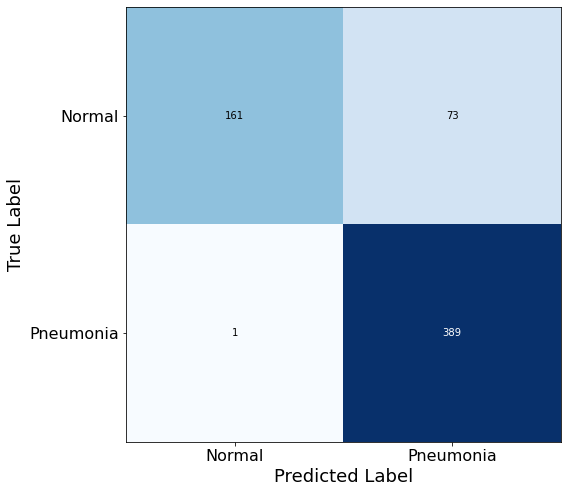

In [30]:
# Plot confusion matrix
print("ResNet Confusion Matrix\n")
cm_resent  = confusion_matrix(labels_resnet, preds_resnet)

# Compute Performance Metrics
tn, fp, fn, tp = cm_resent.ravel()

accuracy = (np.array(preds_resnet) == np.array(labels_resnet)).sum() / len(preds_resnet)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

plt.figure()
plot_confusion_matrix(cm_resent,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

Our model is performing quite well with a F1-score of about 90%. Precision is lower than recall, but this is expected due to the data class imbalance. The weightings can perhaps we tuned to improve the precision. However, recall and precision is balance and one has to be sacrificed for the other.

VGG Confusion Matrix

Accuracy of the model is 0.81
Recall of the model is 0.98
Precision of the model is 0.78
F1 Score of the model is 0.86


<Figure size 432x288 with 0 Axes>

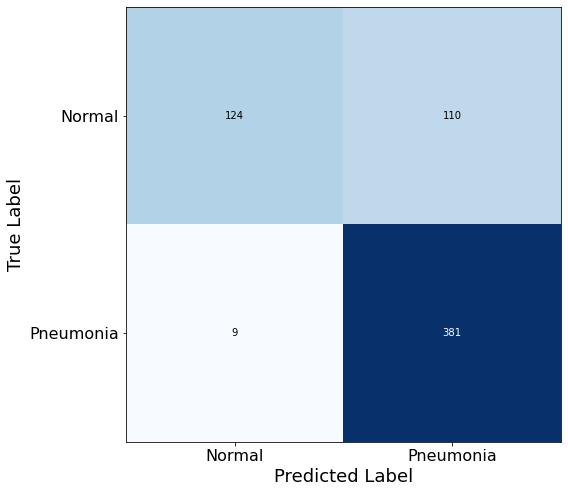

In [31]:
# Plot confusion matrix
print("VGG Confusion Matrix\n")
cm_vgg  = confusion_matrix(labels_vgg, preds_vgg)

# Compute Performance Metrics
tn, fp, fn, tp = cm_vgg.ravel()

accuracy = (np.array(preds_vgg) == np.array(labels_vgg)).sum() / len(preds_vgg)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

plt.figure()
plot_confusion_matrix(cm_vgg,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [37]:
classification_report(labels_resnet, preds_resnet, "ResNet")
classification_report(labels_vgg, preds_vgg, "VGG")

============================== Model Evaluation ==============================
Classifier : ResNet

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.69      0.81       234
           1       0.84      1.00      0.91       390

    accuracy                           0.88       624
   macro avg       0.92      0.84      0.86       624
weighted avg       0.90      0.88      0.88       624

============================== Model Evaluation ==============================
Classifier : VGG

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.53      0.68       234
           1       0.78      0.98      0.86       390

    accuracy                           0.81       624
   macro avg       0.85      0.75      0.77       624
weighted avg       0.83      0.81      0.79       624



<a id='14'></a>
# 14. Prediction vs Actual Labels

Predictions using ResNet




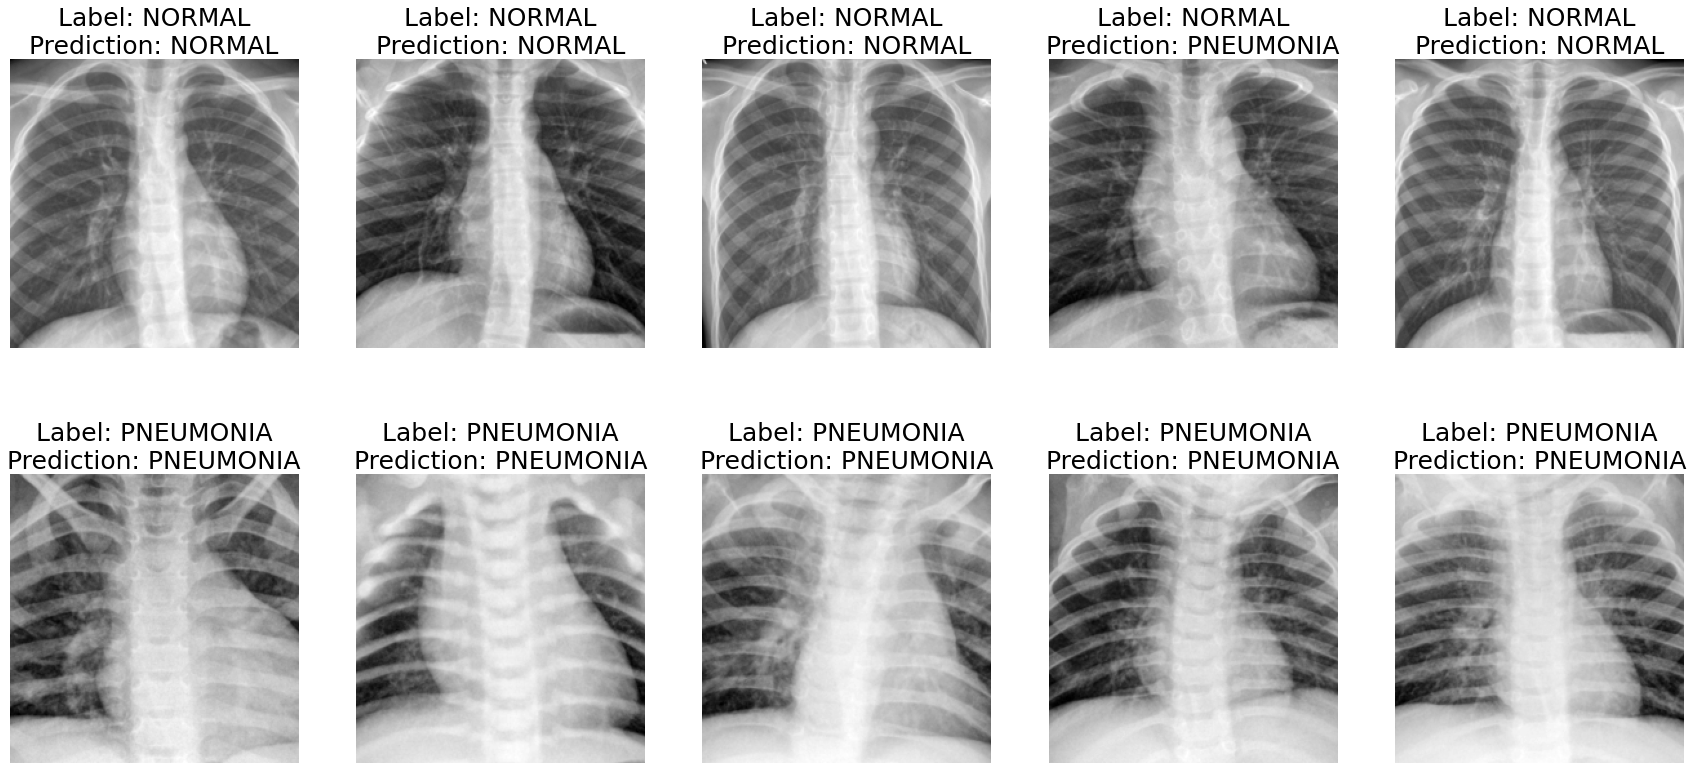

In [33]:
print("Predictions using ResNet\n\n")
# select 5 normal and 5 pneumonia images indices
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1), 
                             np.arange(start=500, stop=505, step=1))) 

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label_resnet = test_dataset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediction: {}'
                            .format(test_dataset.classes[label_resnet], 
                                    test_dataset.classes[preds_resnet[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')
    

Predictions using VGG




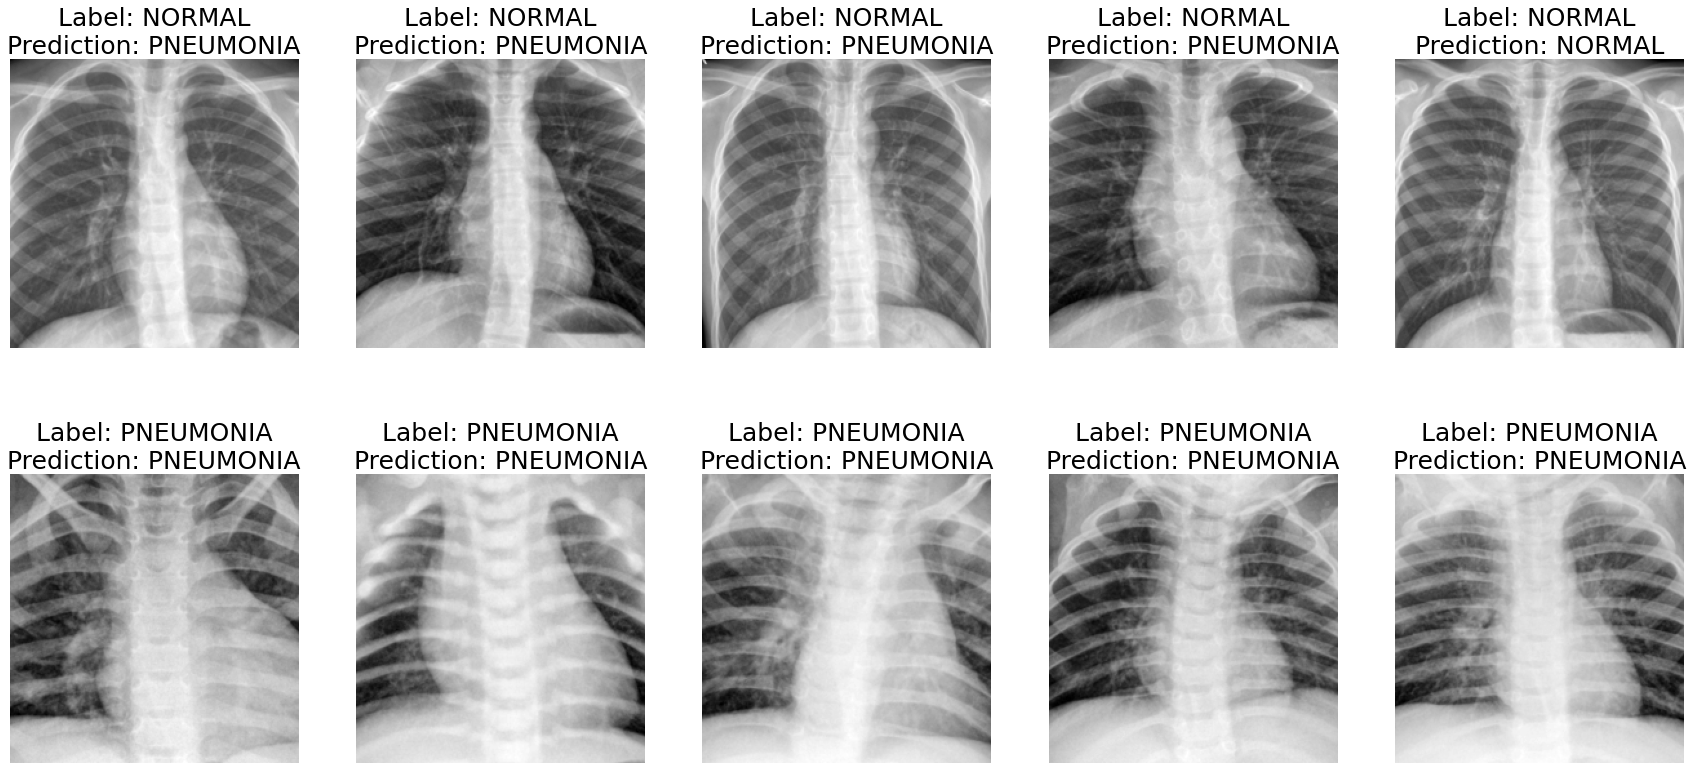

In [34]:
print("Predictions using VGG\n\n")
# select 5 normal and 5 pneumonia images indices
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1), 
                             np.arange(start=500, stop=505, step=1))) 

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label_vgg = test_dataset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediction: {}'
                            .format(test_dataset.classes[label_vgg], 
                                    test_dataset.classes[preds_vgg[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')
    

<a id='15'></a>
# 15. Saving the Best Model

In [38]:
# Save the best Model
'''
bestmodel_resnet = {'model': PneumoniaResnet(),
              'state_dict': model1.state_dict(),
              'optimizer' : optimizer_resnet.state_dict()}

torch.save(bestmodel_resnet, 'PneumoniaResnet.pth')
'''
# this is for loading the model from a previously saved one

"\nbestmodel_resnet = {'model': PneumoniaResnet(),\n              'state_dict': model1.state_dict(),\n              'optimizer' : optimizer_resnet.state_dict()}\n\ntorch.save(bestmodel_resnet, 'PneumoniaResnet.pth')\n"

In [39]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

# if we want to load the model afterwards directly
#model = load_checkpoint('../input/pneumonia-detection-resnets-pytorch/PneumoniaResnet.pth')

<a id='16'></a>
# 16. Conclusion

To summarize, ResNet outperformed VGG in generalizing eventhough its training and validation loss and accuracies were not very clearly saturated but that shows that our VGG model is overfitted on dominant class and that can be seen in few sample predictions as well.

Below are some of the difficulties that this dataset is highly prone to face:

1. Class Imbalance
2. Overfitting

We can use different and advance regularization techniques to see if we get better results or not, but for now this it.

<img src = 'https://t3.ftcdn.net/jpg/02/91/52/22/360_F_291522205_XkrmS421FjSGTMRdTrqFZPxDY19VxpmL.jpg' width="1000">